# Домашнее задание 4

В этом задании мы:
1. Построим классификатор датасета CIFAR с помощью обычных нейросетей и CNN.
2. Поработаем с аугментациями и добьемся большего качества с их помощью.
3. Попрактикуемся с техникой fine-tuning: возьмем готовый MobileNet и дообучим последний слой под нашу задачу.

## Классификация: CNN против обычных сетей

В первой части задания мы повторим то, что проделывалось на лекции.
Но на этот раз будем учить сети до победного, пока их качество не перестанет улучшаться - и сравним результаты.

Также в конце оценим число параметров в каждой сети, чтобы сравнить эффективность CNN и FC при работе с изображениями.

Воспользуемся датасетом CIFAR.

In [1]:
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

train_dataset = CIFAR10(root="./data", train=True, download=True, transform=ToTensor())
test_dataset = CIFAR10(root="./data", train=False, download=True, transform=ToTensor())
train_dataset.classes

100%|██████████| 170M/170M [00:10<00:00, 16.0MB/s] 


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

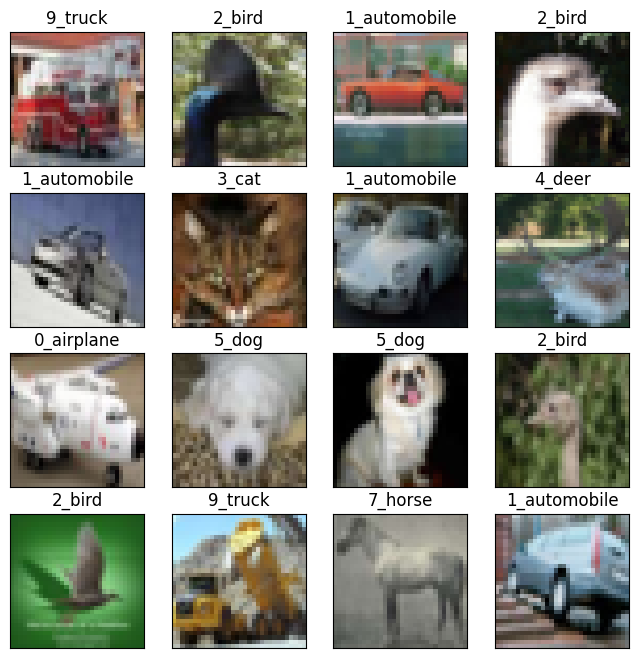

In [2]:
# Посмотрим на dataset

import matplotlib.pyplot as plt
import numpy as np
X_train = train_dataset.data
y_train = train_dataset.targets

# инициализируем случайный генератор
rng = np.random.default_rng(seed=0)
arr = np.arange(X_train.shape[0])
rng.shuffle(arr)

# визуализируем данные
classes = train_dataset.classes

n = 4
fig, ax = plt.subplots(n, n, figsize=(8, 8))
for row in range(n):
    for col in range(n):
        idx = arr[n*row + col]
        ax[row][col].imshow(X_train[idx])
        ax[row][col].set_title(f"{y_train[idx]}_{classes[y_train[idx]]}")
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

In [3]:
X_train[0].shape

(32, 32, 3)

### Задание №1

Создайте два объекта `DataLoader` и сохраните их в переменные `train_loader` и `test_loader` (для тренировочной и тестовой выборки соответственно).

Используйте размер батча 256.

In [3]:
import random

seed = 0
generator = torch.Generator()
generator.manual_seed(seed)

# https://pytorch.org/docs/stable/notes/randomness.html#dataloader
def seed_worker(_):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    generator=generator,
    drop_last=True,
    num_workers=4,
    worker_init_fn=seed_worker,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    generator=generator,
    drop_last=True,
    num_workers=4,
    worker_init_fn=seed_worker,
    pin_memory=True
)

### Задание №2

Обучите полносвязную сеть для классификации CIFAR.

Достаточно 3 блоков "Linear + ReLU".
Ваша задача - вывести accuracy на _тестовой выборке_ на плато.
Т.е. нужно обучить сеть настолько долго, чтобы увидеть, как ее качество перестает расти с ростом числа эпох.
Для этого попробуйте подвигать `lr` и `num_epochs`.


Сдайте в ЛМС предельный accuracy, который может достичь полносвязная сеть.

In [ ]:
# Проверка, что dataloader выдает батчи картинок с их метками
next(iter(train_loader))

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.optim import Adam
import torch.nn.functional as F
import tqdm
import wandb


@dataclass
class TrainConfig:
    lr: float = 1e-2
    num_epochs: int = 10
    img_size: int = 32
    hidden_dim : int = 256


def calc_accuracy(model: nn.Module, loader: DataLoader, device: torch.device):
    count_correct, count_total = 0, 0
    model.eval()
    for img_batch, true_labels in loader:
        img_batch = img_batch.to(device)
        true_labels = true_labels.to(device)
        with torch.no_grad():
            pred_val = model(img_batch).squeeze()

        pred_labels = torch.argmax(pred_val, dim=1)
        count_correct += (pred_labels == true_labels).sum().item()
        count_total += len(true_labels)
    model.train()
    return count_correct / count_total


def plot_accuracy(epoch: int, values: list[float]):
    """Пример:

    >>> acc.append(validation_accuracy)
    >>> plot(i + 1, validation_accuracy)
    """
    clear_output(True)
    plt.title("Epoch %s. Accuracy: %s" % (epoch, values[-1]))
    plt.plot(values)
    plt.grid()
    plt.show()


params = TrainConfig(lr=1e-2, num_epochs=200)
class FcModel(nn.Module):
    def __init__(self, config: TrainConfig):
        super().__init__()
        self.img_size = config.img_size
        self.hidden_dim = config.hidden_dim
        n_channels = 3

        self.net = nn.Sequential(
            nn.Linear(self.img_size * self.img_size * n_channels, self.hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(self.hidden_dim),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(self.hidden_dim),
            nn.Linear(self.hidden_dim, 10),
        )
     
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Схлопнем (N, C, H, W) -> (N, C * H * W)
        x = x.reshape((x.shape[0], -1))
        # И прогоним через линейные слои
        return self.net(x)


def train_loop(
        config: TrainConfig,
        model: nn.Module,
        train_loader: DataLoader,
        test_loader: DataLoader,
        device: torch.device,
        params_subset: list | None = None
):
    if params_subset is None:
        params_subset = model.parameters()
    optimizer = Adam(params_subset, lr=config.lr)
    model.to(device)

    # accuracy тестовой выборки на каждой эпохе обучения будем сохранять в acc
    acc = [] 

    for epoch in range(config.num_epochs):
        print(f"Epoch #{epoch + 1}/#{config.num_epochs}")
        for i, (img_batch, true_labels) in enumerate(tqdm.tqdm(train_loader)):
            step = epoch * len(train_loader) + i
            img_batch, true_labels = img_batch.to(device), true_labels.to(device)

            optimizer.zero_grad()
            pred_labels = model(img_batch).squeeze()
            loss = F.cross_entropy(pred_labels, true_labels)
            loss.backward()
            optimizer.step()

            wandb.log({"loss": loss.cpu().item()}, step=step)
        
        with torch.no_grad():
            acc.append(calc_accuracy(model, test_loader, device))
            # Подсчитаем accuracy на всем валидационном датасете
            wandb.log(
                {"accuracy": acc[-1]}, step=step
            )

        plot_accuracy(epoch, acc)

# Создайте модель, обучите ее
model = FcModel(params)
if torch.cuda.is_available():
    device = torch.device("cuda")

In [ ]:
wandb.init(project="hw-4", name="simple-fc_P100", config=params.__dict__)
train_loop(params, model, train_loader, test_loader=test_loader, device=device)
wandb.finish()

In [ ]:
# решение авторов

import matplotlib.pyplot as plt
from IPython.display import clear_output


@dataclass
class TrainConfig:
    lr: float
    num_epochs: int


def plot_accuracy(epoch: int, values: list[float]):
    """Пример:

    >>> acc.append(validation_accuracy)
    >>> plot(i + 1, validation_accuracy)
    """
    clear_output(True)
    plt.title("Epoch %s. Accuracy: %s" % (epoch, values[-1]))
    plt.plot(values)
    plt.grid()
    plt.show()


def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    config: TrainConfig,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    # Перенос модели на GPU, если доступен
    model = model.to(device)
    val_acc = []
    # Цикл по эпохам
    for i in range(config.num_epochs):
        model.train()  # Переключение в режим обучения

        for X_batch, y_batch in tqdm.tqdm(train_loader):
            # Перенос батча на GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Получение предсказаний модели
            outputs = model(X_batch)

            # Расчёт потерь
            loss = F.cross_entropy(outputs, y_batch)
            loss.backward()  # Обратное распространение ошибки

            # Обновление параметров модели
            optimizer.step()

        # Валидация
        model.eval()  # Переключение в режим валидации
        total_val_acc = 0
        total_val_samples = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # Перенос батча на GPU
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # Получение предсказаний модели
                val_outputs = model(X_batch)

                # Накопление статистики
                total_val_acc += (val_outputs.argmax(1) == y_batch).sum().item()
                total_val_samples += X_batch.size(0)

        # Расчёт средней потери и точности на валидационном наборе
        val_acc.append(total_val_acc / total_val_samples)
        plot_accuracy(i + 1, val_acc)


class SimpleFCNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        return self.fc(x)


torch.manual_seed(987)
params = TrainConfig(lr=1e-3, num_epochs=50)
model = SimpleFCNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=params.lr)
train_loop(model, train_loader, test_loader, optimizer, params)
# Около 0.55 должно выйти

In [18]:
def report_parameters(model: nn.Module):
    print(
        "Суммарное количество параметров:",
        sum(p.nelement() for p in model.parameters()),
    )
    print(c
        "Суммарный размер (Мб) параметров:",
        sum(
            parameter.nelement() * parameter.element_size()
            for parameter in model.parameters()
        )
        / 1024**2,
    )

In [22]:
report_parameters(model)

Суммарное количество параметров: 856074
Суммарный размер (Мб) параметров: 3.2656631469726562


### Задание №3

Теперь постройте и обучите CNN сеть.
Опять же, не используйте глубокую сеть: мы хотим иметь схожее количество параметров для сравнения.

Достаточно будет трех блоков "Conv + ReLU + MaxPool".

In [5]:
from dataclasses import dataclass
import torch

@dataclass
class TrainConfig:
    lr: float = 1e-2
    num_epochs: int = 10
    img_size: int = 32
    hidden_dim : int = 256

 
class CnnModelBase(nn.Module):
    def build_model(self):
        raise NotImplementedError()

    def explain_output(self, x: torch.Tensor):
        # Печатает размеры тензора на выходе каждого слоя
        print("## Модель ##")
        print(model)
        print("## Размерности")
        print("Пришел x:", x.shape)
        current = x
        for one_layer in self.net:
            print("#######")
            print("Слой:".ljust(8), one_layer)
            print("До:".ljust(8), current.shape)
            current = one_layer(current)
            print("После:".ljust(8), current.shape)
        print("## После всей модели")
        print(self(x).shape)

    def __init__(self, num_classes: int = 10, config: TrainConfig = TrainConfig(lr=1e-3, num_epochs=50)):
        super().__init__()
        self.config = config
        # Нам хватит поменьше размерности внутри
        self.hidden_dim = 64
        self.n_channels = 3
        self.net = self.build_model()
        self.head = nn.Linear(in_features=self.hidden_dim, out_features=num_classes)

    def forward(self, x):
        x = self.net(x).squeeze()
        x = self.head(x).squeeze()
        return x

class SimpleCNNModel(CnnModelBase):
    def build_model(self):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=self.n_channels, out_channels=self.hidden_dim, kernel_size=3, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=self.hidden_dim, out_channels=self.hidden_dim, kernel_size=3, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=self.hidden_dim, out_channels=self.hidden_dim, kernel_size=3, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8),
        )


params = TrainConfig(lr=1e-3, num_epochs=50)
model = SimpleCNNModel(config=params)
x, y = next(iter(train_loader))
model.explain_output(x)

## Модель ##
SimpleCNNModel(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (head): Linear(in_features=64, out_features=10, bias=True)
)
## Размерности
Пришел x: torch.Size([64, 3, 32, 32])
#######
Слой:    Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
До:      torch.Size([64, 3, 32, 32])
После:   torch.Size([64, 64, 32, 32])
#######
Слой:    ReLU()
До:      torch.Size([64, 64, 32, 32])
После:   torch.Size([64, 64, 32, 32])
#######
Слой:    MaxPool2d(kernel_size=2, stride=

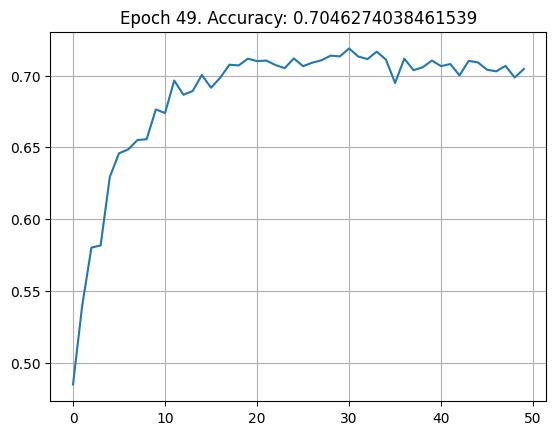

accuracy,▁▃▄▄▅▆▆▆▇▇▇▇█▇██████████████▇███████████
loss,█▅▅▅▃▃▄▃▄▄▃▄▃▂▂▃▂▃▃▂▂▂▃▂▂▁▃▃▂▂▁▂▂▂▂▁▁▁▁▂
accuracy,0.70463
loss,0.39264


In [16]:
wandb.init(project="hw-4", name="simple-CNN-P100", config=params.__dict__)
params = TrainConfig(lr=1e-3, num_epochs=50)
model = SimpleCNNModel(config=params)
train_loop(params, model, train_loader, test_loader=test_loader, device=device)
wandb.finish()

In [ ]:
## решение авторов

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class SimpleCNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Linear(128 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.conv_net(x)
        x = x.view(-1, 128 * 4 * 4)
        return self.fc(x)


torch.manual_seed(987)
model = SimpleCNNModel()

params = TrainConfig(lr=1e-2, num_epochs=50)
optimizer = torch.optim.Adam(model.parameters(), lr=params.lr)
train_loop(model, train_loader, test_loader, optimizer, params)


In [19]:
report_parameters(model)

Суммарное количество параметров: 76298
Суммарный размер (Мб) параметров: 0.29105377197265625


Обратите внимание на качество и на число параметров.
Качество получается выше, а число параметров - на порядок меньше.

Делаем вывод, что CNN позволяют выбивать лучшее качество, чем обычные сети, и при меньшем числе параметров.

Но CNN - не единственный способ улучшить качество при работе с картинками.

### Задание №4
Реализуйте следующие аугментации:
1. Горизонтальное отражение (Horizontal Flip) с вероятностью применения 30%
2. Вращение на угол (Rotate), близкий к 30 градусам, с вероятностью применения около 30%.
3. Random Resized Crop - тут выберите нужные параметры самостоятельно.
4. Normalize. Нормализовать нужно вдоль трех осей изображения. Среднее и std подсчитайте самостоятельно, используя `train_dataset` (в подсчет статистик _нельзя_ включать `test_dataset`).

Используйте библиотеку `albumentations`.
Не забудьте, что `albumentations` работает с numpy-массивами.
Придется перегонять данные из pytorch в numpy-массивы и обратно:

```python
np_array = tensor.numpy()
tensor_back = torch.from_numpy(np_array)
```

Сохраните аугментации в переменную `transforms` и сдайте свой код в ЛМС.

<details>
<summary>Как ваш код будет проверяться</summary>

```python
import albumentations as A

# <Ваш код здесь>

# Затем проверки на переменную transforms
assert some_check(transforms)
assert another_check(transforms)
```
</details>

In [6]:
def calculate_dataset_stats(imgs):
    """Рассчитывает mean и std для каждого канала по всему датасету"""
    means = np.zeros(3)
    stds = np.zeros(3)

    for c in range(3):
        means[c] = imgs[..., c].mean()/255
        stds[c] = imgs[..., c].std()/255
    
    return means.tolist(), stds.tolist()

means, stds = calculate_dataset_stats(train_dataset.data)

In [7]:
calculate_dataset_stats(train_dataset.data)

([0.49139967861519607, 0.48215840839460783, 0.44653091444546567],
 [0.2470322324632819, 0.24348512800005573, 0.26158784172796434])

In [52]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset


class CIFAR10Albumentations(Dataset):
    def __init__(self, root="./data", train=True, download=True, transform=None):
        self.dataset = CIFAR10(root=root, train=train, download=download) 
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

def calculate_dataset_stats(imgs):
    """Рассчитывает mean и std для каждого канала по всему датасету"""
    means = np.zeros(3)
    stds = np.zeros(3)

    for c in range(3):
        means[c] = imgs[..., c].mean()/255
        stds[c] = imgs[..., c].std()/255
    
    return means.tolist(), stds.tolist()

means, stds = calculate_dataset_stats(train_dataset.data)
image_size = 32

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.Rotate(limit=30, p=0.3),
    A.RandomResizedCrop(
        size=(image_size, image_size),          # итоговый размер
        scale=(0.9, 1.0),  # диапазон размера области относительно исходного
        ratio=(0.75, 1.33), # соотношение сторон области (ширина/высота)
        p=0.3
    ),
    A.Normalize(
        mean=means,  # [0.4914, 0.4822, 0.4465]
        std=stds,    # [0.2470, 0.2435, 0.2616]
        max_pixel_value=255.0  # важно: данные в [0, 255]
    ),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Normalize(
        mean=means,  # [0.4914, 0.4822, 0.4465]
        std=stds,    # [0.2470, 0.2435, 0.2616]
        max_pixel_value=255.0  # важно: данные в [0, 255]
    ),
    ToTensorV2()
])
            
# Создаем датасеты
train_dataset = CIFAR10Albumentations(
    root="./data", 
    train=True, 
    download=True, 
    transform=train_transforms
)

test_dataset = CIFAR10Albumentations(
    root="./data", 
    train=False, 
    download=True, 
    transform=test_transforms
)

# Создаем DataLoader
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [18]:
# для LMS
import albumentations as A
from albumentations.pytorch import ToTensorV2

image_size = 32
transforms = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.Rotate(limit=30, p=0.3),
    A.RandomResizedCrop(
        size=(image_size, image_size),          # итоговый размер
        scale=(0.5, 1.0),  # диапазон размера области относительно исходного
        ratio=(0.75, 1.33), # соотношение сторон области (ширина/высота)
        p=0.5
    ),
    A.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616],
        max_pixel_value=255.0  # ответ принимается для max_pixel_value=1.0
    ),
    ToTensorV2()
])

In [ ]:
## вариант авторов

import albumentations as A
from albumentations.pytorch import ToTensorV2

image_size = 32

transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.3),
        A.Rotate(limit=30, p=0.3),
        A.RandomResizedCrop(image_size, image_size, scale=(0.9, 0.9), p=0.3),
        A.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.24703279, 0.24348423, 0.26158753],
            max_pixel_value=1.0,
        ),
        ToTensorV2(),
    ]
)

In [37]:
# Проверка, какое будет правильное значение для max_pixel_value
real_image = train_dataset.data[0]  # первое изображение

# Ваш transforms (полная версия)
your_transforms = A.Compose([
    A.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616],
        max_pixel_value=255.0
    ),
    ToTensorV2()
])

# Применяем
result = your_transforms(image=real_image)['image']

print("ПРОВЕРКА НА РЕАЛЬНЫХ ДАННЫХ")
print("=" * 50)
print(f"Исходное изображение:")
print(f"  - Тип: {real_image.dtype}")
print(f"  - Диапазон: [{real_image.min()}, {real_image.max()}]")
print(f"  - Среднее по каналам (до норм.): {real_image.mean(axis=(0,1))}")

print(f"\nПосле нормализации (с max_pixel_value=255):")
print(f"  - Тип: {result.dtype}")
print(f"  - Диапазон: [{result.min():.3f}, {result.max():.3f}]")
print(f"  - Среднее по каналам: {result.mean(dim=(1,2)).numpy()}")

# Проверка математического ожидания
# Для нормализованных данных среднее должно быть близко к 0
expected_mean = [0.4914, 0.4822, 0.4465]
actual_mean = result.mean(dim=(1,2)).numpy()

print(f"\nОжидаемое среднее после норм. (близко к 0): {actual_mean}")
print(f"Отклонение от 0: {np.abs(actual_mean).mean():.2f}")

# Проверка, что max_pixel_value применился правильно
# Если бы мы забыли max_pixel_value, значения были бы совсем другими
transform_wrong = A.Compose([
    A.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616],
        max_pixel_value=1.0
    ),
    ToTensorV2()
])

wrong_result = transform_wrong(image=real_image)['image']
print(f"\nЕСЛИ БЫ БЕЗ max_pixel_value:")
print(f"  - Диапазон: [{wrong_result.min():.1f}, {wrong_result.max():.2f}]")
print(f"  - Среднее по каналам: {wrong_result.mean(dim=(1,2)).numpy()}")
print(f"  - Это неправильно! Значения слишком большие")

ПРОВЕРКА НА РЕАЛЬНЫХ ДАННЫХ
Исходное изображение:
  - Тип: uint8
  - Диапазон: [0, 255]
  - Среднее по каналам (до норм.): [141.20507812 105.09960938  64.03710938]

После нормализации (с max_pixel_value=255):
  - Тип: torch.float32
  - Диапазон: [-1.989, 2.094]
  - Среднее по каналам: [ 0.25241056 -0.28765777 -0.74684286]

Ожидаемое среднее после норм. (близко к 0): [ 0.25241056 -0.28765777 -0.74684286]
Отклонение от 0: 0.43

ЕСЛИ БЫ БЕЗ max_pixel_value:
  - Диапазон: [-2.0, 1037.03]
  - Среднее по каналам: [569.69104 429.6403  243.08337]
  - Это неправильно! Значения слишком большие


In [38]:
torch.testing.assert_close(result, wrong_result)

AssertionError: Tensor-likes are not close!

Mismatched elements: 3065 / 3072 (99.8%)
Greatest absolute difference: 1034.93994140625 at index (1, 15, 16) (up to 1e-05 allowed)
Greatest relative difference: 1.1212364435195923 at index (2, 3, 1) (up to 1.3e-06 allowed)

## Аугментации
Зачастую аугментации помогают увеличить качество модели.
Объясняется это так: аугментация изображений обогащает датасет новыми картинками, сгенерированными из существующих.
Переобучения не происходит, потому что мы не просто дублируем изображения, а немного изменяем их.
### Задание №5

Обучите CNN с использованием аугментаций.
Как и в прошлых заданиях, держите обучение до конца - пока loss не выйдет на плато.

Ваша задача - получить accuracy выше 76%.
Сдайте в ЛМС:
- код класса модели. Класс должен называться `SimpleCNNModel`;
- .pt файл с обученной моделью;

In [7]:
# Подготовка данных
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import random

# Загрузка датасета
class CIFAR10Albumentations(Dataset):
    def __init__(self, root="./data", train=True, download=True, transform=None):
        self.dataset = CIFAR10(root=root, train=train, download=download)
        self.classes = self.dataset.classes
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

# создание преобразований
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomResizedCrop(
        size=(32, 32),          # итоговый размер
        scale=(0.9, 1.0),  # диапазон размера области относительно исходного
        ratio=(0.75, 1.33), # соотношение сторон области (ширина/высота)
        p=0.5
    ),
    A.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616],
        max_pixel_value=255.0  # важно: данные в [0, 255]
    ),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616],
        max_pixel_value=255.0  # важно: данные в [0, 255]
    ),
    ToTensorV2()
])
            
# Создаем датасеты
train_dataset = CIFAR10Albumentations(
    root="./data", 
    train=True, 
    download=True, 
    transform=train_transforms
)

test_dataset = CIFAR10Albumentations(
    root="./data", 
    train=False, 
    download=True, 
    transform=test_transforms
)

# Создаем DataLoader
seed = 0
generator = torch.Generator()
generator.manual_seed(seed)

# https://pytorch.org/docs/stable/notes/randomness.html#dataloader
def seed_worker(_):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    generator=generator,
    drop_last=True,
    num_workers=4,
    worker_init_fn=seed_worker,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    generator=generator,
    drop_last=True,
    num_workers=4,
    worker_init_fn=seed_worker,
    pin_memory=True
)

100%|██████████| 170M/170M [00:55<00:00, 3.10MB/s] 


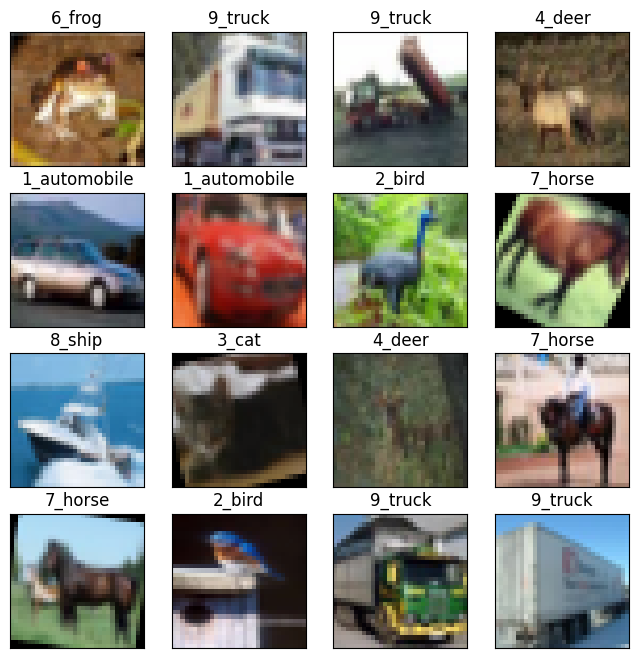

In [8]:
# Посмотрим на dataset

import matplotlib.pyplot as plt
import numpy as np
X_train = train_dataset

# денормализация изображения
def denormalize(tensor, mean, std):
    """
    Денормализует тензор для визуализации
        Args:
        tensor: torch.Tensor shape (C, H, W) в формате после нормализации
        mean: список средних значений для каждого канала
        std: список стандартных отклонений
    """
    # Копируем, чтобы не изменять оригинал
    img = tensor.clone()
    
    # Денормализация: img = img * std + mean
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    
    # Переводим в numpy и меняем порядок осей (C, H, W) -> (H, W, C)
    img = img.numpy().transpose(1, 2, 0)
    
    # Обрезаем до [0, 1] для безопасного отображения
    img = np.clip(img, 0, 1)
    return img

# визуализируем данные
classes = X_train.classes
# параметры нормализации
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]

n = 4
fig, ax = plt.subplots(n, n, figsize=(8, 8))
for row in range(n):
    for col in range(n):
        idx = n*row + col
        image, label = X_train[idx]
        ax[row][col].imshow(denormalize(image, mean, std))
        ax[row][col].set_title(f"{label}_{classes[label]}")
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

In [9]:
from IPython.display import clear_output
from torch.optim import Adam
import torch.nn.functional as F
import tqdm
import wandb

# создание модели
@dataclass
class TrainConfig:
    lr: float = 1e-2
    num_epochs: int = 10
    img_size: int = 32
    hidden_dim : int = 256

 
class CnnModelBase(nn.Module):
    def build_model(self):
        raise NotImplementedError()

    def explain_output(self, x: torch.Tensor):
        # Печатает размеры тензора на выходе каждого слоя
        print("## Модель ##")
        print(model)
        print("## Размерности")
        print("Пришел x:", x.shape)
        current = x
        for one_layer in self.net:
            print("#######")
            print("Слой:".ljust(8), one_layer)
            print("До:".ljust(8), current.shape)
            current = one_layer(current)
            print("После:".ljust(8), current.shape)
        print("## После всей модели")
        print(self(x).shape)

    def __init__(self, num_classes: int = 10, config: TrainConfig = TrainConfig(lr=1e-3, num_epochs=50)):
        super().__init__()
        self.config = config
        # Нам хватит поменьше размерности внутри
        self.hidden_dim = 64
        self.n_channels = 3
        self.net = self.build_model()
        self.head = nn.Linear(in_features=self.hidden_dim, out_features=num_classes)

    def forward(self, x):
        x = self.net(x).squeeze()
        x = self.head(x).squeeze()
        return x

class SimpleCNNModel(CnnModelBase):
    def build_model(self):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=self.n_channels, out_channels=self.hidden_dim, kernel_size=3, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=self.hidden_dim, out_channels=self.hidden_dim, kernel_size=3, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=self.hidden_dim, out_channels=self.hidden_dim, kernel_size=3, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8),
        )


# вывод графика точности на тестовой выборке после каждой эпохи обучения
def plot_accuracy(epoch: int, values: list[float]):
    """Пример:

    >>> acc.append(validation_accuracy)
    >>> plot(i + 1, validation_accuracy)
    """
    clear_output(True)
    plt.title("Epoch %s. Accuracy: %s" % (epoch, values[-1]))
    plt.plot(values)
    plt.grid()
    plt.show()

def calc_accuracy(model: nn.Module, loader: DataLoader, device: torch.device):
    count_correct, count_total = 0, 0
    model.eval()
    for img_batch, true_labels in loader:
        img_batch = img_batch.to(device)
        true_labels = true_labels.to(device)
        with torch.no_grad():
            pred_val = model(img_batch).squeeze()

        pred_labels = torch.argmax(pred_val, dim=1)
        count_correct += (pred_labels == true_labels).sum().item()
        count_total += len(true_labels)
    model.train()
    return count_correct / count_total
    
# Петля обучения сети
def train_loop(
        config: TrainConfig,
        model: nn.Module,
        train_loader: DataLoader,
        test_loader: DataLoader,
        device: torch.device,
        params_subset: list | None = None
):
    if params_subset is None:
        params_subset = model.parameters()
    optimizer = Adam(params_subset, lr=config.lr)
    model.to(device)

    # accuracy тестовой выборки на каждой эпохе обучения будем сохранять в acc
    acc = [] 

    for epoch in range(config.num_epochs):
        print(f"Epoch #{epoch + 1}/#{config.num_epochs}")
        for i, (img_batch, true_labels) in enumerate(tqdm.tqdm(train_loader)):
            step = epoch * len(train_loader) + i
            img_batch, true_labels = img_batch.to(device), true_labels.to(device)

            optimizer.zero_grad()
            pred_labels = model(img_batch).squeeze()
            loss = F.cross_entropy(pred_labels, true_labels)
            loss.backward()
            optimizer.step()

            wandb.log({"loss": loss.cpu().item()}, step=step)
        
        with torch.no_grad():
            acc.append(calc_accuracy(model, test_loader, device))
            # Подсчитаем accuracy на всем валидационном датасете
            wandb.log(
                {"accuracy": acc[-1]}, step=step
            )

        plot_accuracy(epoch, acc)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

params = TrainConfig(lr=1e-3, num_epochs=50)
model = SimpleCNNModel(config=params)
x, y = next(iter(train_loader))
model.explain_output(x)

cuda
## Модель ##
SimpleCNNModel(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (head): Linear(in_features=64, out_features=10, bias=True)
)
## Размерности
Пришел x: torch.Size([64, 3, 32, 32])
#######
Слой:    Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
До:      torch.Size([64, 3, 32, 32])
После:   torch.Size([64, 64, 32, 32])
#######
Слой:    ReLU()
До:      torch.Size([64, 64, 32, 32])
После:   torch.Size([64, 64, 32, 32])
#######
Слой:    MaxPool2d(kernel_size=2, st

In [11]:
# загрузка параметров обученной ранее модели
# model.load_state_dict(torch.load("/kaggle/input/datasets/andreykurdyubov/model-step6/hw4_CNN_augmented_step6.pt"))

<All keys matched successfully>

In [ ]:
wandb.init(project="hw-4", name="CNN_augmented_continue_learning", config=params.__dict__)
params = TrainConfig(lr=1e-3, num_epochs=50)
train_loop(params, model, train_loader, test_loader=test_loader, device=device)
wandb.finish()

In [27]:
# сохранение модели
# torch.save(model.state_dict(), "CNN_augmented.pt")

In [30]:
def report_parameters(model: nn.Module):
    print(
        "Суммарное количество параметров:",
        sum(p.nelement() for p in model.parameters()),
    )
    print("Суммарный размер (Мб) параметров:",
        sum(
            parameter.nelement() * parameter.element_size()
            for parameter in model.parameters()
        )
        / 1024**2,
    )

In [31]:
report_parameters(model)

Суммарное количество параметров: 76298
Суммарный размер (Мб) параметров: 0.29105377197265625


In [28]:

## Решенеие авторов
from torch.utils.data import Dataset


class DatasetWithTransforms(Dataset):
    def __init__(self, original_dataset: Dataset, transforms: A.Compose):
        super().__init__()
        self._transforms = transforms
        self._dataset = original_dataset

    def __len__(self):
        return len(self._dataset)

    def __getitem__(self, index: int):
        img, label = self._dataset[index]
        img_as_np = img.numpy()
        # albumentations принимает картинку в формате (w, h, c), но pytorch хранит в (c, w, h)
        # np_array.transpose(1, 2, 0) сделает так, чтобы сначала шла ось 1, потом ось 2, потом ось 0
        # т.е. (c, w, h) перейдет в (w, h, c)
        #       0  1  2              1  2  0
        transformed = self._transforms(image=img_as_np.transpose(1, 2, 0))["image"]
        return transformed, label


train_dataset_augs = DatasetWithTransforms(train_dataset, transforms)
train_loader_augs = DataLoader(
    train_dataset_augs, batch_size=batch_size, shuffle=True, num_workers=8
)

# Надо не забыть в тесте нормировать картинки на те же статистики, что в train датасете
transforms_test = A.Compose(
    [
        A.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.24703279, 0.24348423, 0.26158753],
            max_pixel_value=1.0,
        ),
        ToTensorV2(),
    ]
)
test_dataset_augs = DatasetWithTransforms(test_dataset, transforms_test)
test_loader_augs = DataLoader(
    test_dataset_augs, batch_size=batch_size, shuffle=False, num_workers=8
)

torch.manual_seed(seed=987)
model = SimpleCNNModel()

params = TrainConfig(lr=1e-3, num_epochs=50)
optimizer = torch.optim.Adam(model.parameters(), lr=params.lr)
train_loop(model, train_loader_augs, test_loader_augs, optimizer, params)
torch.save(model.state_dict(), "model.pt")

Аугментации улучшили качество.

Заметьте, что нормализацию можно было бы применить и в прошлом пункте, чтобы более честно оценить, какой прирост дали развороты и вращения изображения.
Советуем самостоятельно провести эксперимент и увидеть различия.

<details>
    <summary>Какие результаты ожидать</summary>
    У авторов получилось около 73% accuracy при использовании только лишь нормализации. При добавлении остальных аугментаций качество было еще выше.
</details>

## Transfer learning
### Задание №6
Transfer learning состоит в том, чтобы взять готовую сеть и дообучить небольшую ее часть.
В этом задании мы будем учить FC слой в конце MobileNet.

Загрузите предварительно обученную модель из серии `MobileNet`, используйте `MobileNet_V3_large`.

Поменяйте ее последний слой (классификатор) на один линейный слой.
Обучите все это дело, меняя **только** параметры своего слоя (подумайте, что передавать в оптимизатор).
Сохраните обученный слой (и только его) в `model_finetune.pt`.

Сдайте в ЛМС .pt файл и код, создающий вашу модель в переменную `model_finetune`.
Чтобы сдать это задание, достаточно набрать accuracy > 40%.

In [16]:
from torchvision.models.quantization import mobilenet_v3_large
mobilenet_v3_large?

Signature:
mobilenet_v3_large(
    *,
    weights: Union[torchvision.models.quantization.mobilenetv3.MobileNet_V3_Large_QuantizedWeights, torchvision.models.mobilenetv3.MobileNet_V3_Large_Weights, NoneType] = None,
    progress: bool = True,
    quantize: bool = False,
    **kwargs: Any,
) -> torchvision.models.quantization.mobilenetv3.QuantizableMobileNetV3
Docstring:
MobileNetV3 (Large) model from
`Searching for MobileNetV3 <https://arxiv.org/abs/1905.02244>`_.

.. note::
    Note that ``quantize = True`` returns a quantized model with 8 bit
    weights. Quantized models only support inference and run on CPUs.
    GPU inference is not yet supported.

Args:
    weights (:class:`~torchvision.models.quantization.MobileNet_V3_Large_QuantizedWeights` or :class:`~torchvision.models.MobileNet_V3_Large_Weights`, optional): The
        pretrained weights for the model. See
        :class:`~torchvision.models.quantization.MobileNet_V3_Large_QuantizedWeights` below for
        more details, and

In [22]:
def fix_seeds(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)

from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

def make_mobilenet():
    """Vодель mobilenet для fine-tuning.
    
    1. Скачивает готовый обученный MobileNet_V3_large с использованием weights.
    2. Заменяет последний слой в нем на Linear(..., 10).
    3. Инициализирует веса этому слою.
    """
    fix_seeds(0)
    
    # Современный способ (рекомендуется)
    base_model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
    
    # Или самый простой способ - использовать DEFAULT
    # base_model = mobilenet_v3_large(weights='DEFAULT')
    
    # Получаем количество входных признаков последнего слоя
    in_features = base_model.classifier[-1].in_features
    
    # Заменяем последний слой
    base_model.classifier[-1] = nn.Linear(in_features, 10)
    
    # Инициализируем веса нового слоя
    torch.nn.init.xavier_uniform_(base_model.classifier[-1].weight)
    
    return base_model

mobilenet = make_mobilenet()
mobilenet(x).shape

torch.Size([64, 10])

In [23]:
# Крутое описание архитектуры
# Установите библиотеку, если ещё не установлена
# pip install torchinfo

from torchinfo import summary

# Создаем тестовый вход
x = torch.randn(1, 3, 224, 224)
mobilenet = make_mobilenet()

# Краткий summary (рекомендую начать с этого)
summary(mobilenet, input_size=(1, 3, 224, 224))

# Или более детальный summary с показом всех слоев
summary(mobilenet, input_size=(1, 3, 224, 224), depth=5, verbose=1)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 10]                   --
├─Sequential: 1-1                                  [1, 960, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         --
│    │    │    └─Conv2dNormActivation: 4-1         [1, 16, 112, 112]         --
│    │    │    │    └─Conv2d: 5-1                  [1, 16, 112, 112]         144
│    │    │    │    └─BatchNorm2d: 5-2             [1, 16, 112, 112]         32
│    │    │    │    └─ReLU: 5-3  

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 10]                   --
├─Sequential: 1-1                                  [1, 960, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         --
│    │    │    └─Conv2dNormActivation: 4-1         [1, 16, 112, 112]         --
│    │    │    │    └─Conv2d: 5-1                  [1, 16, 112, 112]         144
│    │    │    │    └─BatchNorm2d: 5-2             [1, 16, 112, 112]         32
│    │    │    │    └─ReLU: 5-3  

In [ ]:
print(
    "Суммарное количество параметров:",
    sum(p.nelement() for p in trainable_params),
)
print(
    "Суммарный размер (Мб) параметров:",
    sum(
        parameter.nelement() * parameter.element_size()
        for parameter in trainable_params
    )
    / 1024**2,
)

Качество, возможно, просело, зато учим намного меньше параметров.

## Задание №7
Возьмите предпоследний слой вашей CNN модели (тот, что до классификатора).
Этот слой выдает вектора.

Возьмите любой объект из класса 0, подсчитайте его косинусную схождесть со всеми остальными объектами из класса 0, усредните.
Затем подсчитайте то же число, только против всех объектов из класса 1, тоже усредните.
Отправьте в ЛМС два числа, разделенные запятой. Например, "1, 1".

In [ ]:
...

#### Небольшой бонус
Эмбеддинги можно визуализировать, используя t-SNE.
Посмотрите, что получается, попробуйте объяснить картину.

Если модель достаточно качественная, то схожие классы должны собираться в одну кучку, при этом у кучек должны прослеживаться границы.
Конечно же, не забывайте про выбросы.

In [ ]:
from sklearn.manifold import TSNE

result = torch.empty((0, 2048))
labels = []
with torch.no_grad():
    embedding_model.cpu()
    for x_batch, y_batch in test_loader_augs:
        embedding = embedding_model(x_batch).flatten(1)
        embedding /= embedding.norm()
        result = torch.concat((result, embedding))
        labels.extend(y_batch.tolist())

tsne = TSNE(random_state=42)
plot_data = tsne.fit_transform(result.numpy())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
scatter = ax.scatter(
    plot_data[:, 0],
    plot_data[:, 1],
    c=labels,
    cmap="viridis",
    edgecolor="k",
    s=20,
    alpha=1,
)
plt.colorbar(scatter)